#### 폰트 설정 및 라이브러리 설치 

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


# 서울시 상권분석 서비스에서 전처리 한 최종 데이터 파일 last.csv 파일 불러오기
# 군집화 완료한 cluster1부터 cluster5까지 불러오기

In [3]:
data = pd.read_csv('last.csv')
data.drop(columns='점포수', inplace=True)

cluster1 = pd.read_csv('cluster1.csv')
cluster2 = pd.read_csv('cluster2.csv')
cluster3 = pd.read_csv('cluster3.csv')
cluster4 = pd.read_csv('cluster4.csv')
cluster5 = pd.read_csv('cluster5.csv')

# 모델링에 사용할 데이터 전처리

In [4]:
# 교통시설 수는 지하철 역 수, 버스 정거장 수, 공항 수, 철도 역 수, 버스 터미널 수의 합으로 계산
data['교통시설_수'] = data['지하철_역_수'] + data['버스_정거장_수'] + data['공항_수'] + data['철도_역_수'] + data['버스_터미널_수']

# 학교 수는 유치원 수, 초등학교 수, 중학교 수, 고등학교 수, 대학교 수의 합으로 계산
data['학교_수'] = data['유치원_수'] + data['초등학교_수'] + data['중학교_수'] + data['고등학교_수'] + data['대학교_수']

# 기타 집객시설 수는 집객시설 수에서 교통시설 수와 학교 수를 뺀 값으로 계산
data['기타_집객시설_수'] = data['집객시설_수'] - data['지하철_역_수'] - data['버스_정거장_수'] - data['공항_수'] - data['철도_역_수'] - data['버스_터미널_수'] - data['초등학교_수'] - data['중학교_수'] - data['고등학교_수'] - data['대학교_수']

# 분석에 사용하지 않을 열들은 drop_columns 리스트에 담겨 있으며, 이 열들은 데이터프레임에서 삭제
drop_columns = ['지하철_역_수', '버스_정거장_수', '공항_수', '철도_역_수', '버스_터미널_수', '집객시설_수',
                '관공서_수', '은행_수', '종합병원_수', '일반_병원_수', '약국_수',
                '유치원_수', '초등학교_수', '중학교_수', '고등학교_수', '대학교_수', '백화점_수', '슈퍼마켓_수', '극장_수', '숙박_시설_수']

# 위에서 정의한 열들을 데이터프레임에서 삭제
data = data.drop(columns=drop_columns)


In [5]:
# '상주인구'가 열 이름에 포함된 모든 열을 'resident_columns' 리스트에 담음
resident_columns = [col for col in data.columns if '상주인구' in col]

# '생활인구'가 열 이름에 포함된 모든 열을 'living_columns' 리스트에 담음
living_columns = [col for col in data.columns if '생활인구' in col]

# '직장_인구'가 열 이름에 포함된 모든 열을 'work_columns' 리스트에 담음
work_columns = [col for col in data.columns if '직장_인구' in col]


In [6]:
# 데이터프레임에서 주어진 열들을 삭제
data.drop(columns=['총_직장_인구_수', '남성_직장_인구_수', '여성_직장_인구_수',
                   '총_생활인구_수', '남성_생활인구_수', '여성_생활인구_수',
                   '총_상주인구_수', '남성_상주인구_수', '여성_상주인구_수'], inplace=True)

In [7]:
# 비경제 활동 불가능 연령대의 상주인구와 경제 활동 가능 연령대의 상주인구 열을 리스트에 저장
non_economic_resident_columns = ['연령대_10_상주인구_수', '연령대_60_이상_상주인구_수']
economic_resident_columns = [
    '연령대_20_상주인구_수',
    '연령대_30_상주인구_수',
    '연령대_40_상주인구_수',
    '연령대_50_상주인구_수'
]

# 비경제 활동 불가능 연령대의 생활인구와 경제 활동 가능 연령대의 생활인구 열을 리스트에 저장
non_economic_living_columns = ['연령대_10_생활인구_수', '연령대_60_이상_생활인구_수']
economic_living_columns = [
    '연령대_20_생활인구_수',
    '연령대_30_생활인구_수',
    '연령대_40_생활인구_수',
    '연령대_50_생활인구_수'
]

# 비경제 활동 불가능 연령대의 직장인구와 경제 활동 가능 연령대의 직장인구 열을 리스트에 저장
non_economic_work_columns = ['연령대_10_직장_인구_수', '연령대_60_이상_직장_인구_수']
economic_work_columns = [
    '연령대_20_직장_인구_수',
    '연령대_30_직장_인구_수',
    '연령대_40_직장_인구_수',
    '연령대_50_직장_인구_수'
]

# 상기 열들을 데이터프레임에서 삭제
data = data.drop(non_economic_resident_columns + economic_resident_columns +
                 non_economic_living_columns + economic_living_columns +
                 non_economic_work_columns + economic_work_columns, axis=1)

# '_amount' 또는 '_prob'가 열 이름에 포함된 열들을 리스트에 저장
columns_to_drop = [
    col for col in data.columns if '_amount' in col or '_prob' in col 
]

# 데이터프레임에서 위에서 선택한 열들을 삭제
data = data.drop(columns=columns_to_drop)

# 수정된 데이터프레임의 처음 몇 행을 출력
data.head()


,상권_코드,월_평균_소득_금액,소득_구간_코드,운영_영업_개월_평균,폐업_영업_개월_평균,서울_운영_영업_개월_평균,서울_폐업_영업_개월_평균,남성연령대_10_상주인구_수,남성연령대_20_상주인구_수,남성연령대_30_상주인구_수,...,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,교통시설_수,학교_수,기타_집객시설_수
0,2110001,4.453866e+06,8.0625,98.5000,61.4375,110.1875,53.5625,105.0000,81.1250,51.125,...,2458.852699,109.510440,911.907102,1150.841903,1733.157315,2038.034517,1403.714062,4.5625,0.0000,4.6875
1,2110002,3.363814e+06,7.0000,131.3750,60.9375,110.1875,53.5625,41.8125,25.1250,29.125,...,13575.698055,887.768065,6381.697933,5654.243959,6618.587135,6446.506474,5148.741909,4.0000,0.0000,14.6875
2,2110003,3.540374e+06,7.0000,115.5625,57.8750,110.1875,53.5625,279.0625,244.8750,185.125,...,2483.022330,281.721923,1355.550478,936.750965,1269.679864,1240.204039,831.389037,6.2500,0.0000,9.4375
3,2110004,2.658326e+06,6.0000,155.1250,77.8125,110.1875,53.5625,32.7500,31.1250,27.750,...,1201.051098,47.036149,265.494807,318.650785,587.035335,721.010926,716.296848,2.0000,0.0000,3.9375
4,2110005,3.696801e+06,7.1875,117.2500,58.1875,110.1875,53.5625,160.3125,119.5625,98.375,...,2739.711102,143.256112,1304.587301,1131.586194,1590.647099,1207.356451,676.489609,5.3125,0.6875,12.4375


In [8]:
# 클러스터 1에 해당하는 상권 코드를 가진 행의 'cluster' 열 값을 'cluster1'로 설정
data.loc[data['상권_코드'].isin(cluster1['상권_코드']), 'cluster'] = 'cluster1'

# 클러스터 2에 해당하는 상권 코드를 가진 행의 'cluster' 열 값을 'cluster2'로 설정
data.loc[data['상권_코드'].isin(cluster2['상권_코드']), 'cluster'] = 'cluster2'

# 클러스터 3에 해당하는 상권 코드를 가진 행의 'cluster' 열 값을 'cluster3'로 설정
data.loc[data['상권_코드'].isin(cluster3['상권_코드']), 'cluster'] = 'cluster3'

# 클러스터 4에 해당하는 상권 코드를 가진 행의 'cluster' 열 값을 'cluster4'로 설정
data.loc[data['상권_코드'].isin(cluster4['상권_코드']), 'cluster'] = 'cluster4'

# 클러스터 5에 해당하는 상권 코드를 가진 행의 'cluster' 열 값을 'cluster5'로 설정
data.loc[data['상권_코드'].isin(cluster5['상권_코드']), 'cluster'] = 'cluster5'

# 'cluster' 열을 출력하여 클러스터 정보를 확인합니다.
data['cluster']


0       cluster3
1       cluster1
2       cluster5
3       cluster3
4       cluster5
          ...   
1055    cluster5
1056    cluster4
1057    cluster1
1058    cluster1
1059    cluster1
Name: cluster, Length: 1060, dtype: object

In [9]:
# 분기당_매출_금액이 1e+09 이상인 상권_코드 제외하고 학습
data = data[data['상권_코드'] != 2110065]
data = data[data['상권_코드'] != 2110164]
data = data[data['상권_코드'] != 2110116]
data = data[data['상권_코드'] != 2110788]
data = data[data['상권_코드'] != 2110131]
data = data[data['상권_코드'] != 2110137]

In [10]:
# 'cluster' 열을 삭제하여 해당 열을 데이터프레임에서 제거
data.drop(columns='cluster', inplace=True)

In [11]:
# 클러스터 1에 해당하는 상권 코드를 가진 행들을 'data1' 데이터프레임에 저장
data1 = data[data['상권_코드'].isin(cluster1['상권_코드'])]

# 클러스터 2에 해당하는 상권 코드를 가진 행들을 'data2' 데이터프레임에 저장
data2 = data[data['상권_코드'].isin(cluster2['상권_코드'])]

# 클러스터 3에 해당하는 상권 코드를 가진 행들을 'data3' 데이터프레임에 저장
data3 = data[data['상권_코드'].isin(cluster3['상권_코드'])]

# 클러스터 4에 해당하는 상권 코드를 가진 행들을 'data4' 데이터프레임에 저장
data4 = data[data['상권_코드'].isin(cluster4['상권_코드'])]

# 클러스터 5에 해당하는 상권 코드를 가진 행들을 'data5' 데이터프레임에 저장
data5 = data[data['상권_코드'].isin(cluster5['상권_코드'])]

# 'data1', 'data2', 'data3', 'data4', 'data5' 데이터프레임에서 '상권_코드' 열을 삭제
data1.drop(columns=['상권_코드'], inplace=True)
data2.drop(columns=['상권_코드'], inplace=True)
data3.drop(columns=['상권_코드'], inplace=True)
data4.drop(columns=['상권_코드'], inplace=True)
data5.drop(columns=['상권_코드'], inplace=True)


/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_26980/404843827.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.drop(columns=['상권_코드'], inplace=True)
/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_26980/404843827.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.drop(columns=['상권_코드'], inplace=True)
/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_26980/404843827.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [12]:
import numpy as np

# 데이터프레임 리스트 생성
dataframes = [data1, data2, data3, data4, data5]

percentiles = [0.33, 0.66]
#percentiles = [0.2, 0.4, 0.6, 0.8]
#percentiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

results = []

# 각 percentile 별로 처리
for percentile in percentiles:
    percentile_values = []
    
    # 각 데이터프레임 별로 처리
    for df in dataframes:
        percentile_value = df['주말_매출_금액'].quantile(percentile)
        percentile_values.append(percentile_value)
    
    # 해당 percentile에서의 평균 계산
    avg_value = np.mean(percentile_values)
    results.append(avg_value)

# 결과 출력
for idx, percentile in enumerate(percentiles):
    print(f"{percentile:.1f} percentile 평균 값: {results[idx]}")

results = [0] + results + [float('inf')]

# 각 데이터프레임 별로 처리
for df in dataframes:
    df['주말_매출_범주'] = pd.cut(df['주말_매출_금액'], bins=results, labels=range(0,3), right=False)

# 결과 출력 (data1을 예시로 출력)
print(data1[ '주말_매출_범주'].unique().sort_values())
print(data2[ '주말_매출_범주'].unique().sort_values())
print(data3[ '주말_매출_범주'].unique().sort_values())
print(data4[ '주말_매출_범주'].unique().sort_values())
print(data5[ '주말_매출_범주'].unique().sort_values())

0.3 percentile 평균 값: 33067837.6329663
0.7 percentile 평균 값: 56059909.93446863
[0, 1, 2]
Categories (3, int64): [0 < 1 < 2]
[0, 1, 2]
Categories (3, int64): [0 < 1 < 2]
[0, 1, 2]
Categories (3, int64): [0 < 1 < 2]
[0, 1, 2]
Categories (3, int64): [0 < 1 < 2]
[0, 1, 2]
Categories (3, int64): [0 < 1 < 2]


/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_26980/3778365014.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['주말_매출_범주'] = pd.cut(df['주말_매출_금액'], bins=results, labels=range(0,3), right=False)
/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_26980/3778365014.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['주말_매출_범주'] = pd.cut(df['주말_매출_금액'], bins=results, labels=range(0,3), right=False)
/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_26980/3778365014.py:33:

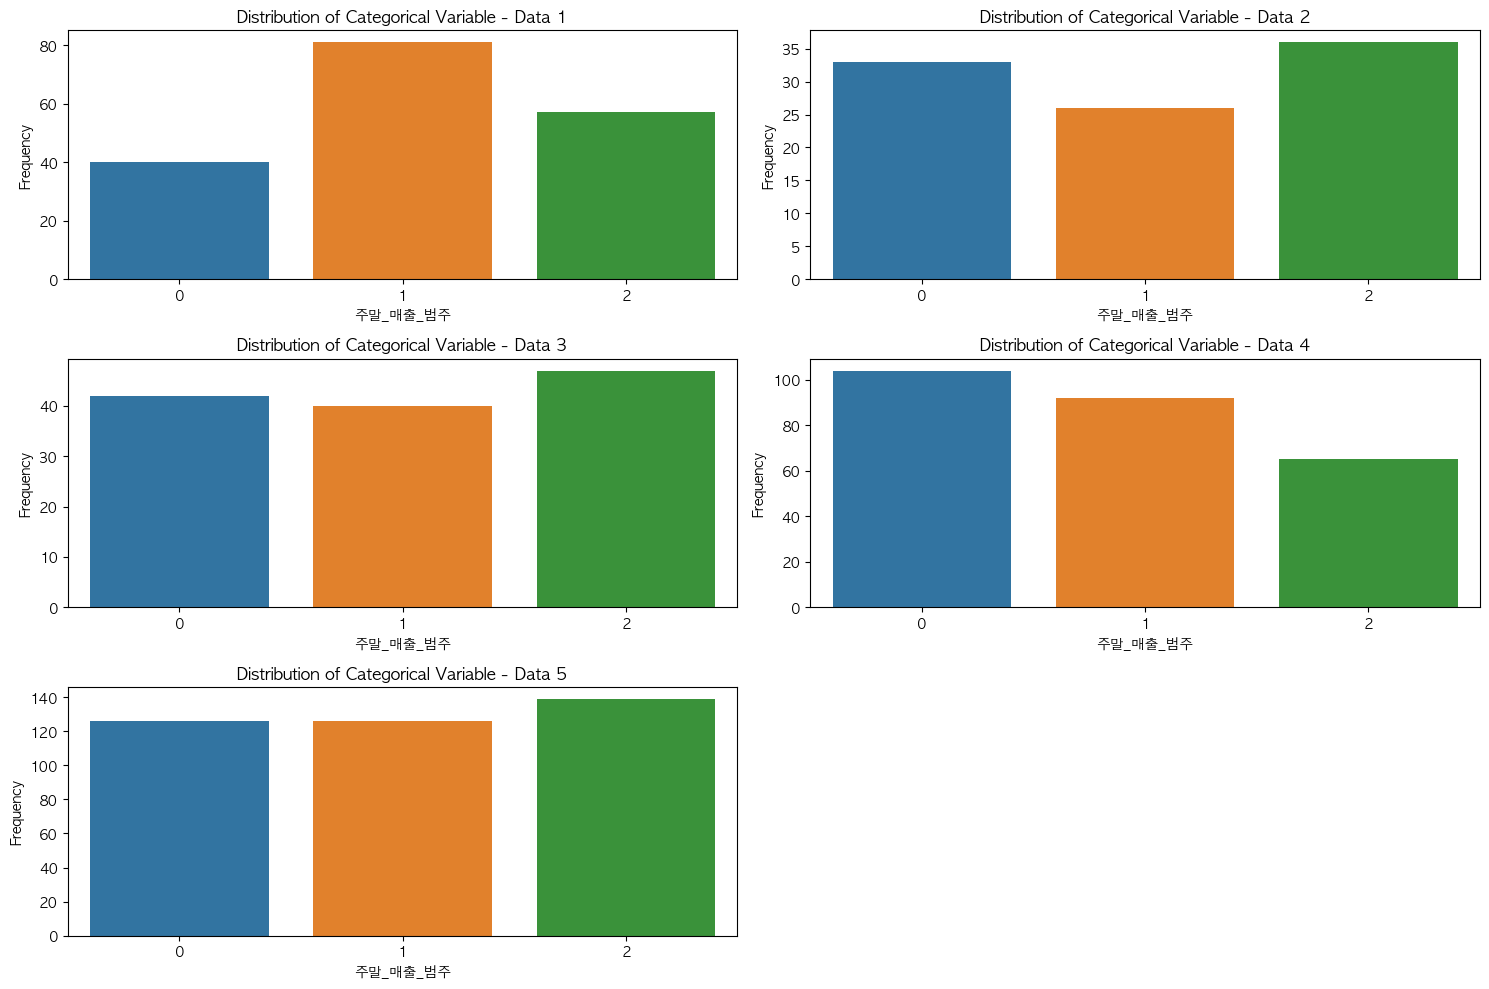

In [13]:
# 데이터 프레임 리스트 생성
dataframes = [data1, data2, data3, data4, data5]
num_rows = 3
num_cols = 2

# 그래프 그리기
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for idx, df in enumerate(dataframes):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col]
    
    category_counts = df['주말_매출_범주'].value_counts()
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f"Distribution of Categorical Variable - Data {idx+1}")
    ax.set_xlabel("주말_매출_범주")
    ax.set_ylabel("Frequency")

# 빈 서브플롯 제거
for idx in range(len(dataframes), num_rows*num_cols):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()


# Cluster1 랜덤포레스트(그리드 서치를 통한 하이퍼 파라미터 조정)

#### n_estimators: 랜덤 포레스트에서 생성할 트리의 개수
#### max_depth: 랜덤 포레스트의 개별 트리의 최대 깊이
#### max_features: 각각의 트리가 선택할 수 있는 최대 특성의 개수
#### min_samples_split: 노드를 분할하기 위한 최소한의 샘플 개수
#### min_samples_leaf: 말단 노드(리프 노드)가 가져야 할 최소한의 샘플 개수

Index(['주말_매출_범주', '남성연령대_10_상주인구_수', '남성연령대_20_상주인구_수', '남성연령대_30_상주인구_수',
       '남성연령대_40_상주인구_수', '남성연령대_50_상주인구_수', '남성연령대_60_이상_상주인구_수',
       '여성연령대_10_상주인구_수', '여성연령대_20_상주인구_수', '여성연령대_30_상주인구_수',
       '여성연령대_40_상주인구_수', '여성연령대_50_상주인구_수', '여성연령대_60_이상_상주인구_수',
       '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수',
       '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수',
       '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수',
       '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수', '여성연령대_60_이상_직장_인구_수', '전체_임대료',
       '점포_수', '유사_업종_점포_수', '프랜차이즈_점포_수', '주중_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '교통시설_수', '학교_수', '기타_집객시설_수'],
      dtype='object')
Best Hyperparameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report:
               precision    recall  f1-score   suppo

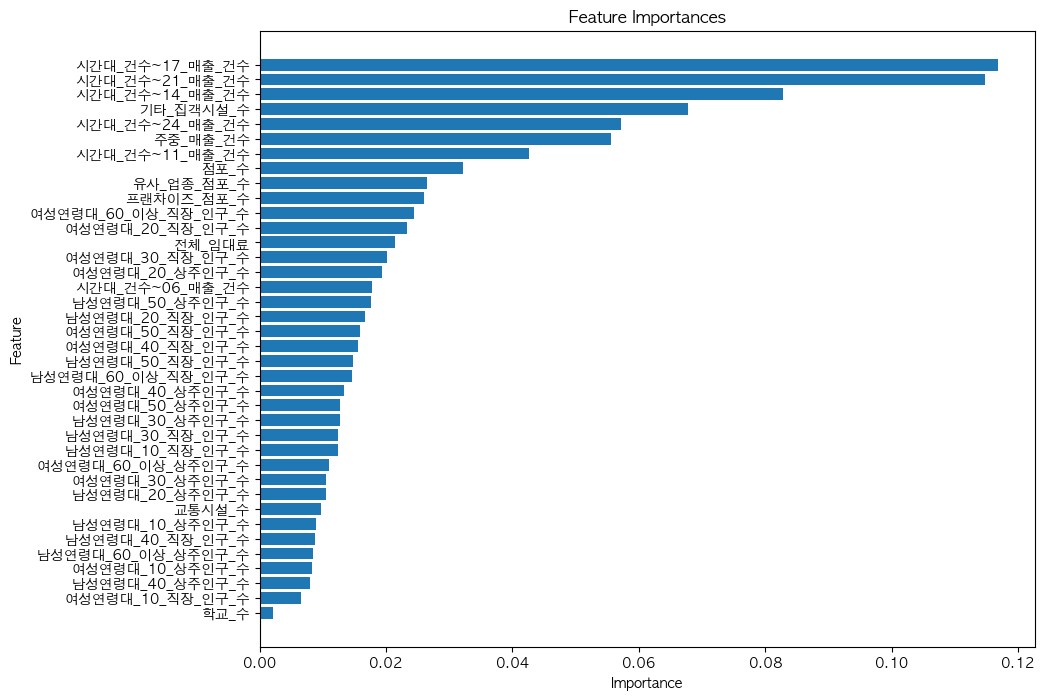

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np


# 클래스 개수 설정
num_classes = 3

# 제거할 열 선택
columns_to_drop = [
    col for col in data1.columns
    if '1층' in col or '분기당_매출_건수' in col or '율' in col or '0_매출_건수' in col or '이상_매출_건수' in col or '소득_구간_코드' in col or '평균' in col or '폐업' in col or '개업' in col or '주말_매출_건수' in col or '남성_매출_건수' in col or '여성_매출_건수' in col or '생활' in col or '가구' in col or '서울' in col or '0_매출_건수' in col or '요일' in col or '매출_비율' in col or '매출_금액' in col 
    if col != '주말_매출_범주'  # '주중_매출_범주'를 '주말_매출_범주'로 변경
]

# 선택한 열 제거
data1_drop = data1.drop(columns=columns_to_drop)

# '주말_매출_범주' 열 분리
code = pd.DataFrame({'주말_매출_범주': data1_drop['주말_매출_범주'].tolist()})
data1_drop.drop(columns=['주말_매출_범주'], inplace=True)

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data1_drop)

# 스케일링된 데이터를 DataFrame으로 변환
data_scaled_df = pd.DataFrame(data_scaled, columns=data1_drop.columns)

# 스케일링된 데이터와 '주말_매출_범주' 결합
data_scaled_df = pd.concat([code, data_scaled_df], axis=1)

print(data_scaled_df.columns)

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(data_scaled_df.drop(columns=['주말_매출_범주']), 
                                                    data_scaled_df['주말_매출_범주'],
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=102)

# 랜덤 포레스트 모델 초기화
model = RandomForestClassifier(n_jobs=-1, random_state=102)

# 그리드 서치 설정
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': np.arange(5, 20),
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5
)

# 그리드 서치 수행
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# 분류 보고서 출력
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# 변수 중요도 추출
feature_importances = best_model.feature_importances_

# 변수 중요도 시각화
importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df.to_string())

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Cluster2 랜덤포레스트(그리드 서치를 통한 하이퍼 파라미터 조정)

#### n_estimators: 랜덤 포레스트에서 생성할 트리의 개수
#### max_depth: 랜덤 포레스트의 개별 트리의 최대 깊이
#### max_features: 각각의 트리가 선택할 수 있는 최대 특성의 개수
#### min_samples_split: 노드를 분할하기 위한 최소한의 샘플 개수
#### min_samples_leaf: 말단 노드(리프 노드)가 가져야 할 최소한의 샘플 개수

In [15]:
data1 = data2

Index(['주말_매출_범주', '남성연령대_10_상주인구_수', '남성연령대_20_상주인구_수', '남성연령대_30_상주인구_수',
       '남성연령대_40_상주인구_수', '남성연령대_50_상주인구_수', '남성연령대_60_이상_상주인구_수',
       '여성연령대_10_상주인구_수', '여성연령대_20_상주인구_수', '여성연령대_30_상주인구_수',
       '여성연령대_40_상주인구_수', '여성연령대_50_상주인구_수', '여성연령대_60_이상_상주인구_수',
       '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수',
       '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수',
       '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수',
       '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수', '여성연령대_60_이상_직장_인구_수', '전체_임대료',
       '점포_수', '유사_업종_점포_수', '프랜차이즈_점포_수', '주중_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '교통시설_수', '학교_수', '기타_집객시설_수'],
      dtype='object')
Best Hyperparameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Classification Report:
               precision    recall  f1-score   suppo

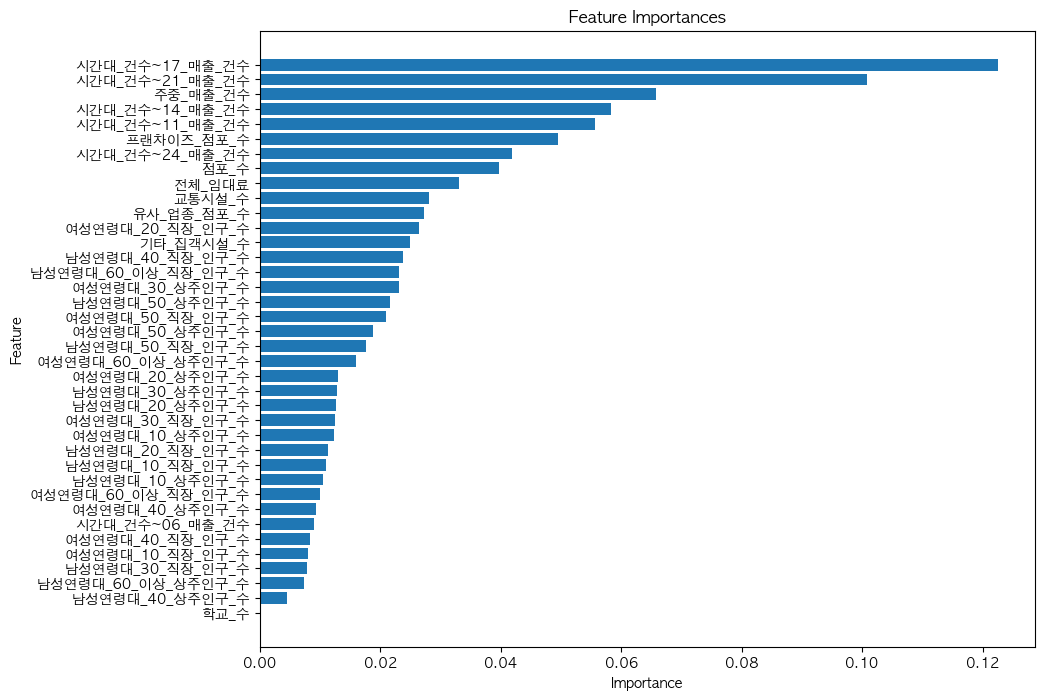

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np


# 클래스 개수 설정
num_classes = 3

# 제거할 열 선택
columns_to_drop = [
    col for col in data1.columns
    if '1층' in col or '분기당_매출_건수' in col or '율' in col or '0_매출_건수' in col or '이상_매출_건수' in col or '소득_구간_코드' in col or '평균' in col or '폐업' in col or '개업' in col or '주말_매출_건수' in col or '남성_매출_건수' in col or '여성_매출_건수' in col or '생활' in col or '가구' in col or '서울' in col or '0_매출_건수' in col or '요일' in col or '매출_비율' in col or '매출_금액' in col 
    if col != '주말_매출_범주'  # '주중_매출_범주'를 '주말_매출_범주'로 변경
]

# 선택한 열 제거
data1_drop = data1.drop(columns=columns_to_drop)

# '주말_매출_범주' 열 분리
code = pd.DataFrame({'주말_매출_범주': data1_drop['주말_매출_범주'].tolist()})
data1_drop.drop(columns=['주말_매출_범주'], inplace=True)

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data1_drop)

# 스케일링된 데이터를 DataFrame으로 변환
data_scaled_df = pd.DataFrame(data_scaled, columns=data1_drop.columns)

# 스케일링된 데이터와 '주말_매출_범주' 결합
data_scaled_df = pd.concat([code, data_scaled_df], axis=1)

print(data_scaled_df.columns)

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(data_scaled_df.drop(columns=['주말_매출_범주']), 
                                                    data_scaled_df['주말_매출_범주'],
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=102)

# 랜덤 포레스트 모델 초기화
model = RandomForestClassifier(n_jobs=-1, random_state=102)

# 그리드 서치 설정
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': np.arange(5, 20),
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5
)

# 그리드 서치 수행
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# 분류 보고서 출력
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# 변수 중요도 추출
feature_importances = best_model.feature_importances_

# 변수 중요도 시각화
importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df.to_string())

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Cluster3 랜덤포레스트(그리드 서치를 통한 하이퍼 파라미터 조정)

#### n_estimators: 랜덤 포레스트에서 생성할 트리의 개수
#### max_depth: 랜덤 포레스트의 개별 트리의 최대 깊이
#### max_features: 각각의 트리가 선택할 수 있는 최대 특성의 개수
#### min_samples_split: 노드를 분할하기 위한 최소한의 샘플 개수
#### min_samples_leaf: 말단 노드(리프 노드)가 가져야 할 최소한의 샘플 개수

In [17]:
data1 = data3

Index(['주말_매출_범주', '남성연령대_10_상주인구_수', '남성연령대_20_상주인구_수', '남성연령대_30_상주인구_수',
       '남성연령대_40_상주인구_수', '남성연령대_50_상주인구_수', '남성연령대_60_이상_상주인구_수',
       '여성연령대_10_상주인구_수', '여성연령대_20_상주인구_수', '여성연령대_30_상주인구_수',
       '여성연령대_40_상주인구_수', '여성연령대_50_상주인구_수', '여성연령대_60_이상_상주인구_수',
       '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수',
       '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수',
       '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수',
       '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수', '여성연령대_60_이상_직장_인구_수', '전체_임대료',
       '점포_수', '유사_업종_점포_수', '프랜차이즈_점포_수', '주중_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '교통시설_수', '학교_수', '기타_집객시설_수'],
      dtype='object')
Best Hyperparameters: {'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report:
               precision    recall  f1-score   supp

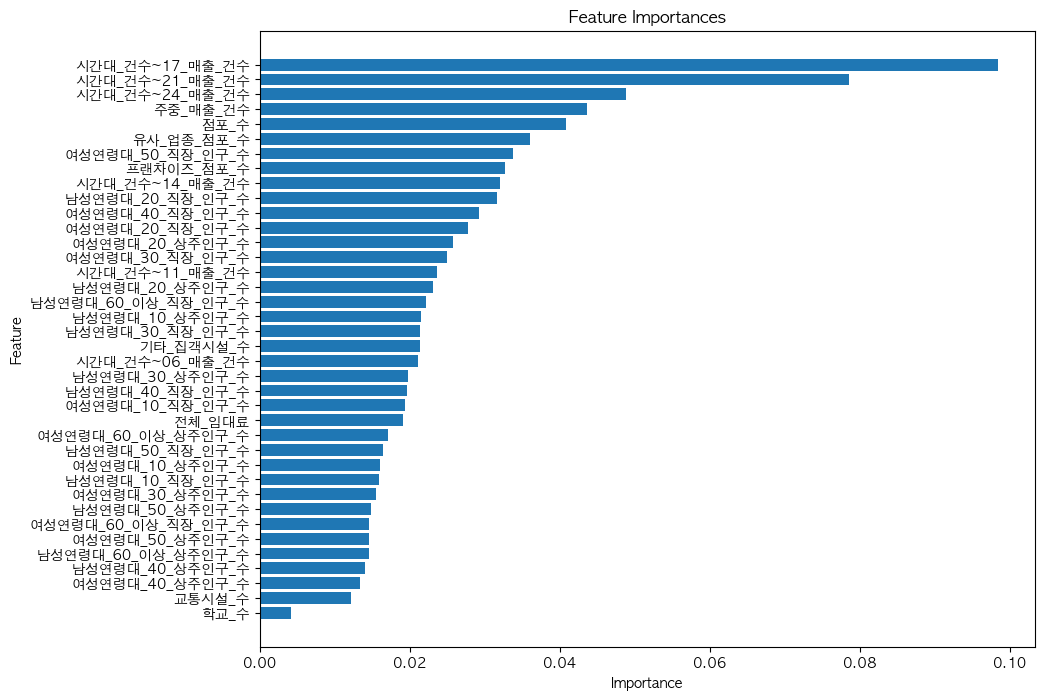

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np


# 클래스 개수 설정
num_classes = 3

# 제거할 열 선택
columns_to_drop = [
    col for col in data1.columns
    if '1층' in col or '분기당_매출_건수' in col or '율' in col or '0_매출_건수' in col or '이상_매출_건수' in col or '소득_구간_코드' in col or '평균' in col or '폐업' in col or '개업' in col or '주말_매출_건수' in col or '남성_매출_건수' in col or '여성_매출_건수' in col or '생활' in col or '가구' in col or '서울' in col or '0_매출_건수' in col or '요일' in col or '매출_비율' in col or '매출_금액' in col 
    if col != '주말_매출_범주'  # '주중_매출_범주'를 '주말_매출_범주'로 변경
]

# 선택한 열 제거
data1_drop = data1.drop(columns=columns_to_drop)

# '주말_매출_범주' 열 분리
code = pd.DataFrame({'주말_매출_범주': data1_drop['주말_매출_범주'].tolist()})
data1_drop.drop(columns=['주말_매출_범주'], inplace=True)

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data1_drop)

# 스케일링된 데이터를 DataFrame으로 변환
data_scaled_df = pd.DataFrame(data_scaled, columns=data1_drop.columns)

# 스케일링된 데이터와 '주말_매출_범주' 결합
data_scaled_df = pd.concat([code, data_scaled_df], axis=1)

print(data_scaled_df.columns)

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(data_scaled_df.drop(columns=['주말_매출_범주']), 
                                                    data_scaled_df['주말_매출_범주'],
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=102)

# 랜덤 포레스트 모델 초기화
model = RandomForestClassifier(n_jobs=-1, random_state=102)

# 그리드 서치 설정
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': np.arange(5, 20),
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5
)

# 그리드 서치 수행
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# 분류 보고서 출력
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# 변수 중요도 추출
feature_importances = best_model.feature_importances_

# 변수 중요도 시각화
importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df.to_string())

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Cluster4 랜덤포레스트(그리드 서치를 통한 하이퍼 파라미터 조정)

#### n_estimators: 랜덤 포레스트에서 생성할 트리의 개수
#### max_depth: 랜덤 포레스트의 개별 트리의 최대 깊이
#### max_features: 각각의 트리가 선택할 수 있는 최대 특성의 개수
#### min_samples_split: 노드를 분할하기 위한 최소한의 샘플 개수
#### min_samples_leaf: 말단 노드(리프 노드)가 가져야 할 최소한의 샘플 개수

In [19]:
data1 = data4

Index(['주말_매출_범주', '남성연령대_10_상주인구_수', '남성연령대_20_상주인구_수', '남성연령대_30_상주인구_수',
       '남성연령대_40_상주인구_수', '남성연령대_50_상주인구_수', '남성연령대_60_이상_상주인구_수',
       '여성연령대_10_상주인구_수', '여성연령대_20_상주인구_수', '여성연령대_30_상주인구_수',
       '여성연령대_40_상주인구_수', '여성연령대_50_상주인구_수', '여성연령대_60_이상_상주인구_수',
       '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수',
       '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수',
       '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수',
       '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수', '여성연령대_60_이상_직장_인구_수', '전체_임대료',
       '점포_수', '유사_업종_점포_수', '프랜차이즈_점포_수', '주중_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '교통시설_수', '학교_수', '기타_집객시설_수'],
      dtype='object')
Best Hyperparameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 50}
Classification Report:
               precision    recall  f1-score   suppo

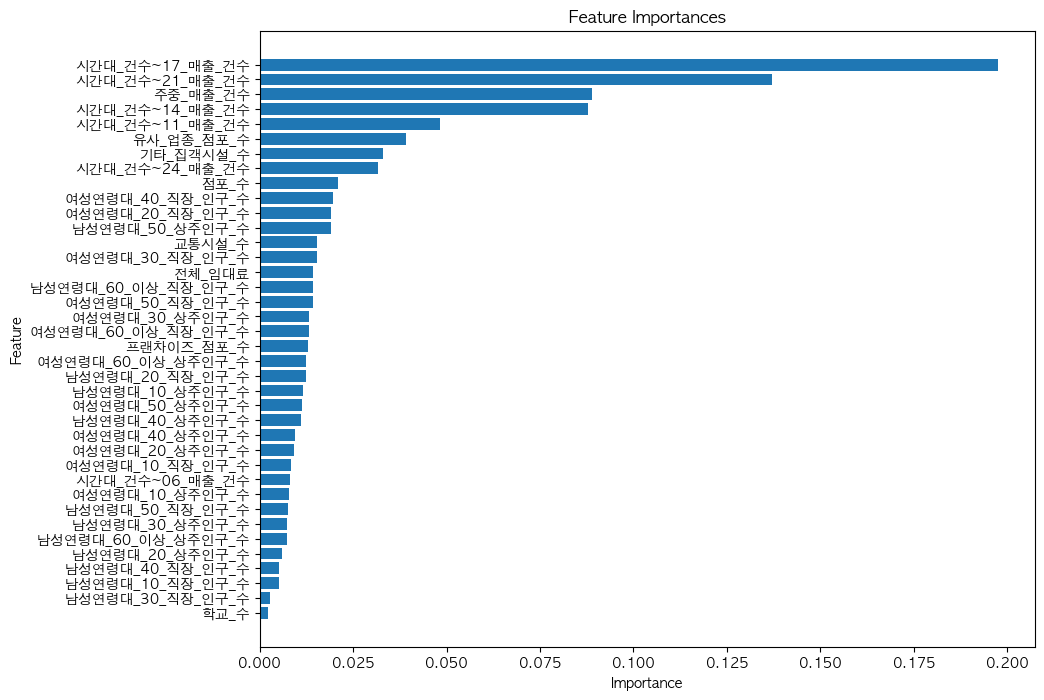

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np


# 클래스 개수 설정
num_classes = 3

# 제거할 열 선택
columns_to_drop = [
    col for col in data1.columns
    if '1층' in col or '분기당_매출_건수' in col or '율' in col or '0_매출_건수' in col or '이상_매출_건수' in col or '소득_구간_코드' in col or '평균' in col or '폐업' in col or '개업' in col or '주말_매출_건수' in col or '남성_매출_건수' in col or '여성_매출_건수' in col or '생활' in col or '가구' in col or '서울' in col or '0_매출_건수' in col or '요일' in col or '매출_비율' in col or '매출_금액' in col 
    if col != '주말_매출_범주'  # '주중_매출_범주'를 '주말_매출_범주'로 변경
]

# 선택한 열 제거
data1_drop = data1.drop(columns=columns_to_drop)

# '주말_매출_범주' 열 분리
code = pd.DataFrame({'주말_매출_범주': data1_drop['주말_매출_범주'].tolist()})
data1_drop.drop(columns=['주말_매출_범주'], inplace=True)

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data1_drop)

# 스케일링된 데이터를 DataFrame으로 변환
data_scaled_df = pd.DataFrame(data_scaled, columns=data1_drop.columns)

# 스케일링된 데이터와 '주말_매출_범주' 결합
data_scaled_df = pd.concat([code, data_scaled_df], axis=1)

print(data_scaled_df.columns)

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(data_scaled_df.drop(columns=['주말_매출_범주']), 
                                                    data_scaled_df['주말_매출_범주'],
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=102)

# 랜덤 포레스트 모델 초기화
model = RandomForestClassifier(n_jobs=-1, random_state=102)

# 그리드 서치 설정
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': np.arange(5, 20),
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5
)

# 그리드 서치 수행
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# 분류 보고서 출력
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# 변수 중요도 추출
feature_importances = best_model.feature_importances_

# 변수 중요도 시각화
importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df.to_string())

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

# Cluster5 랜덤포레스트(그리드 서치를 통한 하이퍼 파라미터 조정)

#### n_estimators: 랜덤 포레스트에서 생성할 트리의 개수
#### max_depth: 랜덤 포레스트의 개별 트리의 최대 깊이
#### max_features: 각각의 트리가 선택할 수 있는 최대 특성의 개수
#### min_samples_split: 노드를 분할하기 위한 최소한의 샘플 개수
#### min_samples_leaf: 말단 노드(리프 노드)가 가져야 할 최소한의 샘플 개수

In [21]:
data1 = data5

Index(['주말_매출_범주', '남성연령대_10_상주인구_수', '남성연령대_20_상주인구_수', '남성연령대_30_상주인구_수',
       '남성연령대_40_상주인구_수', '남성연령대_50_상주인구_수', '남성연령대_60_이상_상주인구_수',
       '여성연령대_10_상주인구_수', '여성연령대_20_상주인구_수', '여성연령대_30_상주인구_수',
       '여성연령대_40_상주인구_수', '여성연령대_50_상주인구_수', '여성연령대_60_이상_상주인구_수',
       '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수',
       '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수',
       '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수',
       '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수', '여성연령대_60_이상_직장_인구_수', '전체_임대료',
       '점포_수', '유사_업종_점포_수', '프랜차이즈_점포_수', '주중_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '교통시설_수', '학교_수', '기타_집객시설_수'],
      dtype='object')
Best Hyperparameters: {'max_depth': 14, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Classification Report:
               precision    recall  f1-score   sup

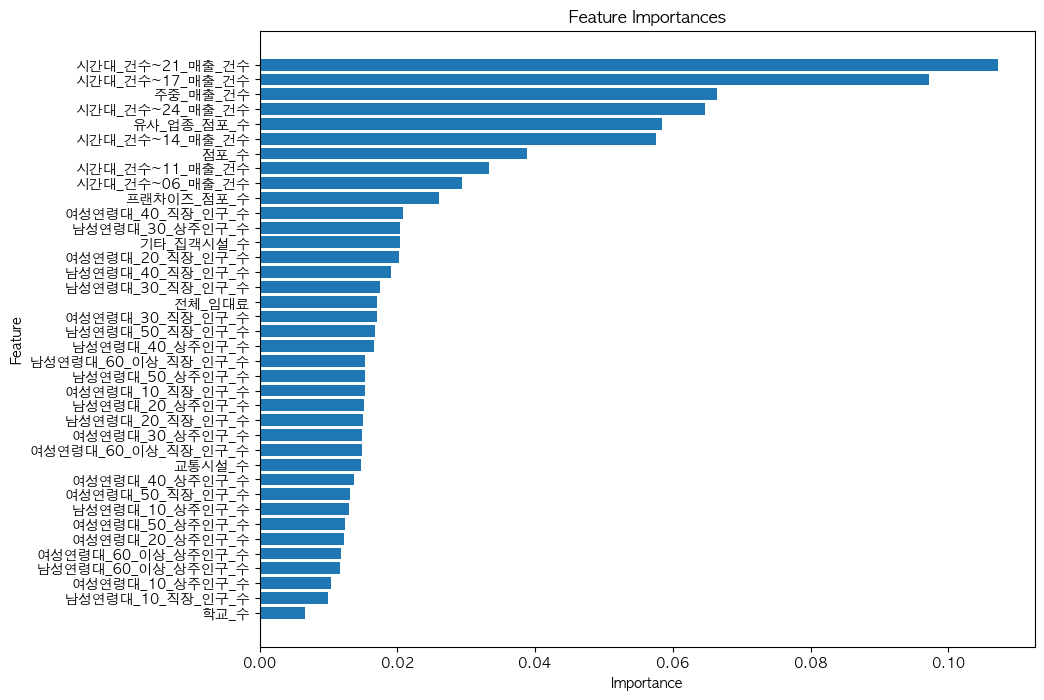

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np


# 클래스 개수 설정
num_classes = 3

# 제거할 열 선택
columns_to_drop = [
    col for col in data1.columns
    if '1층' in col or '분기당_매출_건수' in col or '율' in col or '0_매출_건수' in col or '이상_매출_건수' in col or '소득_구간_코드' in col or '평균' in col or '폐업' in col or '개업' in col or '주말_매출_건수' in col or '남성_매출_건수' in col or '여성_매출_건수' in col or '생활' in col or '가구' in col or '서울' in col or '0_매출_건수' in col or '요일' in col or '매출_비율' in col or '매출_금액' in col 
    if col != '주말_매출_범주'  # '주중_매출_범주'를 '주말_매출_범주'로 변경
]

# 선택한 열 제거
data1_drop = data1.drop(columns=columns_to_drop)

# '주말_매출_범주' 열 분리
code = pd.DataFrame({'주말_매출_범주': data1_drop['주말_매출_범주'].tolist()})
data1_drop.drop(columns=['주말_매출_범주'], inplace=True)

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data1_drop)

# 스케일링된 데이터를 DataFrame으로 변환
data_scaled_df = pd.DataFrame(data_scaled, columns=data1_drop.columns)

# 스케일링된 데이터와 '주말_매출_범주' 결합
data_scaled_df = pd.concat([code, data_scaled_df], axis=1)

print(data_scaled_df.columns)

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(data_scaled_df.drop(columns=['주말_매출_범주']), 
                                                    data_scaled_df['주말_매출_범주'],
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=102)

# 랜덤 포레스트 모델 초기화
model = RandomForestClassifier(n_jobs=-1, random_state=102)

# 그리드 서치 설정
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': np.arange(5, 20),
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5
)

# 그리드 서치 수행
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# 분류 보고서 출력
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# 변수 중요도 추출
feature_importances = best_model.feature_importances_

# 변수 중요도 시각화
importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df.to_string())

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()
